In [1]:
import ipywidgets as widgets
from ipywidgets import HBox, VBox
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
%matplotlib inline

In [2]:
%%time
import boto3
import re
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri

role = get_execution_role()
training_image = get_image_uri(boto3.Session().region_name, 'image-classification')

print(training_image)

811284229777.dkr.ecr.us-east-1.amazonaws.com/image-classification:1
CPU times: user 533 ms, sys: 46.6 ms, total: 580 ms
Wall time: 597 ms


In [3]:
minbatch_freq_slider = widgets.FloatSlider(
    value=2,
    min=1,
    max=150,
    step=1,
    description='Mini batch size:',
    readout_format='d',
)
epochs_freq_slider = widgets.FloatSlider(
    value=2,
    min=10,
    max=200,
    step=1,
    description='Epochs :',
    readout_format='d',
)


In [4]:
range_slider = widgets.FloatRangeSlider(
    value=[-1., +1.],
    min=-5., max=+5., step=0.1,
    description='xlim:',
    readout_format='.1f',
)
optimizer_buttons = widgets.ToggleButtons(
    options=['sgd', 'adam', 'rmsprop'],
    description='Color:',
)
bgr_checkbox = widgets.Checkbox(
    value=False,
    description='colored images',
    disabled=False
)
bucket_textbox = widgets.Text(
    value='S3 bucket',
    description='S3 Bucket:',
)
imdir_textbox = widgets.Text(
    value='Image source',
    description='Image directory:',
)
imwidth_textbox = widgets.BoundedIntText(
    value=224,
    min=0,
    max=1000,
    step=1,
    description='Image width',
)
imheight_textbox = widgets.BoundedIntText(
    value=224,
    min=0,
    max=1000,
    step=1,
    description='Image height',
)
lr_textbox =widgets.BoundedFloatText(
    value=0.01,
    min=0,
    max=10.0,
    step=0.001,
    description='learning rate',
    disabled=False
)

pretrained_checkbox=widgets.Checkbox(
    value=False,
    description='Use pretrained',
    disabled=False
)
prep_data_button = widgets.Button(
    description='Prepare data',

)

run_button = widgets.Button(
    description='Run classifier',

)



In [5]:
tab1 = VBox(children=[bucket_textbox,imdir_textbox, prep_data_button])
tab2 =VBox(children=[bucket_textbox,
                      imdir_textbox,
                     prep_data_button,
                      bgr_checkbox,
                      imwidth_textbox,
                      imheight_textbox,
                      minbatch_freq_slider,
                      epochs_freq_slider,
                      lr_textbox,
                      optimizer_buttons,
                      pretrained_checkbox
                      ])

In [5]:
!ls

im2rec.py	   my_data_train.lst  my_data_val.lst
imgs		   my_data_train.rec  my_data_val.rec
my_data_train.idx  my_data_val.idx    quick_cv_prototyper.ipynb


In [6]:
import subprocess
import os
def download_data(bucket, img_dir):
    s3_dest=os.path.join(bucket,img_dir)
    subprocess.call(["aws", "s3","cp","--recursive","s3://"+s3_dest,'./imgs'])
 

In [7]:
from IPython.display import clear_output
import os
import boto3

        
def upload_to_s3(channel, file):
    s3 = boto3.resource('s3')
    data = open(file, "rb")
    key = channel + '/' + file
    s3.Bucket(bucket_textbox.value).put_object(Key=key, Body=data)
    
def on_prep_data_button_clicked(b):
    bucket=bucket_textbox.value
    img_dir=imdir_textbox.value
    download_data(bucket, img_dir)
    im2rec_path = './im2rec.py'
    data_path = os.path.join(os.getcwd(),'imgs')
    prefix_path = os.path.join(os.getcwd(),'my_data')
    with open(os.devnull, 'wb') as devnull:
        subprocess.check_call(['python', im2rec_path, '--list', '--recursive', '--train-ratio=0.75', prefix_path, data_path],
                              stdout=devnull)
    with open(os.devnull, 'wb') as devnull:
        subprocess.check_call(['python', im2rec_path, '--num-thread=16', '--resize=480','--pass-through', '--train-ratio=0.75', prefix_path, data_path],
                              stdout=devnull)  
        
    upload_to_s3('validation', 'my_data_val.rec')
    upload_to_s3('train', 'my_data_train.rec')
    upload_to_s3('validation_ls', 'my_data_val.lst')
    upload_to_s3('train_ls', 'my_data_train.lst')
    class_opts = widgets.VBox()
    opts_children=[bgr_checkbox,
                      imwidth_textbox,
                      imheight_textbox,
                      minbatch_freq_slider,
                      epochs_freq_slider,
                      lr_textbox,
                      optimizer_buttons,
                      pretrained_checkbox,
                       run_button
                  ]
    class_opts.children=[i for i in opts_children]
    display(class_opts)
    print('done')
    
#def on_run_button_clicked(b):
#    for c in cb_container.children:
#        if not c.value:
#            plots.set_visible(False)
#        else:
#            plots.set_visible(True)
#    plt.legend()
#    plt.draw()
#    print(bucket_textbox.value)
prep_data_button.on_click(on_prep_data_button_clicked)

#text.on_submit(handle_submit)
#plt.show()

In [10]:
%%time
import time
from time import gmtime, strftime
import boto3
import re
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri

role = get_execution_role()
training_image = get_image_uri(boto3.Session().region_name, 'image-classification')
def define_vars():
    image_shape=str(2*int(bgr_checkbox.value)+1)+','+str(imwidth_textbox.value)+','+str(imheight_textbox.value)
    num_layers=50
    num_training_samples=590
    num_classes=6
    mini_batch_size=minbatch_freq_slider.value
    epochs=epochs_freq_slider.value
    learning_rate=lr_textbox.value
    use_pretrained_model=int(pretrained_checkbox.value)
    return image_shape,num_layers,num_training_samples,num_classes,mini_batch_size,epochs,learning_rate,use_pretrained_model
def config_params():
    s3 = boto3.client('s3')
    # create unique job name 
    job_name_prefix = 'byo-imageclassification'
    timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
    job_name = job_name_prefix + timestamp
    image_shape,num_layers,num_training_samples,num_classes,mini_batch_size,epochs,learning_rate,use_pretrained_model = define_vars()

def on_run_button_clicked(b):
    s3 = boto3.client('s3')
    # create unique job name 
    job_name_prefix = 'byo-imageclassification'
    timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
    job_name = job_name_prefix + timestamp
    image_shape,num_layers,num_training_samples,num_classes,mini_batch_size,epochs,learning_rate,use_pretrained_model = define_vars()


    training_params = \
    {
        # specify the training docker image
        "AlgorithmSpecification": {
            "TrainingImage": training_image,
            "TrainingInputMode": "File"
        },
        "RoleArn": role,
        "OutputDataConfig": {
            "S3OutputPath": 's3://{}/{}/output'.format(bucket_textbox.value, job_name_prefix)
        },
        "ResourceConfig": {
            "InstanceCount": 1,
            "InstanceType": "ml.p3.2xlarge",
            "VolumeSizeInGB": 50
        },
        "TrainingJobName": job_name,
        "HyperParameters": {
            "image_shape": image_shape,
            "num_layers": str(int(num_layers)),
            "num_training_samples": str(int(num_training_samples)),
            "num_classes": str(int(num_classes)),
            "mini_batch_size": str(int(mini_batch_size)),
            "epochs": str(int(epochs)),
            "learning_rate": str(learning_rate),
            "use_pretrained_model": str(use_pretrained_model),
            "resize":str(imwidth_textbox.value)

        },
        "StoppingCondition": {
            "MaxRuntimeInSeconds": 360000
        },
    #Training data should be inside a subdirectory called "train"
    #Validation data should be inside a subdirectory called "validation"
    #The algorithm currently only supports fullyreplicated model (where data is copied onto each machine)
        "InputDataConfig": [
            {
                "ChannelName": "train",
                "DataSource": {
                    "S3DataSource": {
                        "S3DataType": "S3Prefix",
                        "S3Uri": 's3://{}/train/'.format(bucket_textbox.value),
                        "S3DataDistributionType": "FullyReplicated"
                    }
                },
                "ContentType": "application/x-recordio",
                "CompressionType": "None"
            },
            {
                "ChannelName": "validation",
                "DataSource": {
                    "S3DataSource": {
                        "S3DataType": "S3Prefix",
                        "S3Uri": 's3://{}/validation/'.format(bucket_textbox.value),
                        "S3DataDistributionType": "FullyReplicated"
                    }
                },
                "ContentType": "application/x-recordio",
                "CompressionType": "None"
            }
        ]
    }
    print('Training job name: {}'.format(job_name))
    print('\nInput Data Location: {}'.format(training_params['InputDataConfig'][0]['DataSource']['S3DataSource']))

    sagemaker = boto3.client(service_name='sagemaker')
    sagemaker.create_training_job(**training_params)

    # confirm that the training job has started
    status = sagemaker.describe_training_job(TrainingJobName=job_name)['TrainingJobStatus']
    print('Training job current status: {}'.format(status))

    try:
        # wait for the job to finish and report the ending status
        sagemaker.get_waiter('training_job_completed_or_stopped').wait(TrainingJobName=job_name)
        training_info = sagemaker.describe_training_job(TrainingJobName=job_name)
        status = training_info['TrainingJobStatus']
        print("Training job ended with status: " + status)
    except:
        print('Training failed to start')
         # if exception is raised, that means it has failed
        message = sagemaker.describe_training_job(TrainingJobName=job_name)['FailureReason']
        print('Training failed with the following error: {}'.format(message))
        
run_button.on_click(on_run_button_clicked)


CPU times: user 135 ms, sys: 6.15 ms, total: 142 ms
Wall time: 162 ms


In [11]:
tab = widgets.Tab(children=[tab1, tab2])
tab.set_title(0, 'Image Classification')
tab.set_title(1, 'Object Detection')
VBox(children=[tab])

VkJveChjaGlsZHJlbj0oVGFiKGNoaWxkcmVuPShWQm94KGNoaWxkcmVuPShUZXh0KHZhbHVlPXUnbXktZGwtbW9kZWxzMicsIGRlc2NyaXB0aW9uPXUnUzMgQnVja2V0OicpLCBUZXh0KHZhbHXigKY=


VkJveChjaGlsZHJlbj0oQ2hlY2tib3godmFsdWU9VHJ1ZSwgZGVzY3JpcHRpb249dSdjb2xvcmVkIGltYWdlcycpLCBCb3VuZGVkSW50VGV4dCh2YWx1ZT0yMjQsIGRlc2NyaXB0aW9uPXUnSW3igKY=


done
Training job name: byo-imageclassification-2018-10-21-12-53-54

Input Data Location: {'S3DataType': 'S3Prefix', 'S3DataDistributionType': 'FullyReplicated', 'S3Uri': 's3://my-dl-models2/train/'}
Training job current status: InProgress


/home/ec2-user/anaconda3/envs/mxnet_p27/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


Text(value=u'', description=u'Domain to ping')

<IPython.core.display.Javascript object>


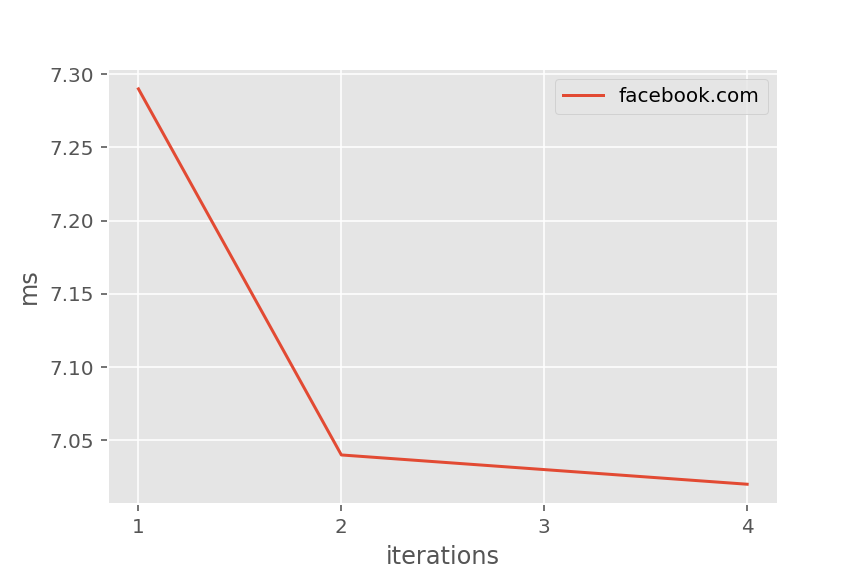

HBox()

Button(description=u'Update the graph', style=ButtonStyle())

AttributeError: 'dict' object has no attribute 'set_visible'

In [20]:
%matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import *
from IPython.display import display
from IPython.html import widgets
plt.style.use('ggplot')
 

    
NUMBER_OF_PINGS = 4
 
# displaying the text widget
text = widgets.Text(description="Domain to ping", width=200)
display(text)
 
# preparing the plot 
data = pd.DataFrame()
x = range(1,NUMBER_OF_PINGS+1)
plots = dict()
fig, ax = plt.subplots()
plt.xlabel('iterations')
plt.ylabel('ms')
plt.xticks(x)
plt.show()
 
# preparing a container to put in created checkbox per domain
checkboxes = []
cb_container = widgets.HBox()
display(cb_container)
 
# add button that updates the graph based on the checkboxes
button = widgets.Button(description="Update the graph")
 
# function to deal with the added domain name
def handle_submit(sender):
    # a part of the magic inside python : pinging
    res = !ping -c {NUMBER_OF_PINGS} {text.value}
    hits = res.grep('64 bytes').fields(-2).s.replace("time=","").split()
    if len(hits) == 0:
        print("Domain gave error on pinging")
    else:
         # rebuild plot based on ping result
        data = hits
        data = np.array(data, dtype=np.float32)
        plots, = ax.plot(x, data, label=text.value)
        plt.legend()
        plt.draw()
        # add a new checkbox for the new domain
        checkboxes.append(widgets.Checkbox(description = text.value, value=True, width=90))
        cb_container.children=[i for i in checkboxes]
        if len(checkboxes) == 1:
            display(button)
 
# function to deal with the checkbox update button       
def on_button_clicked(b):
    for c in cb_container.children:
        if not c.value:
            plots.set_visible(False)
        else:
            plots.set_visible(True)
    plt.legend()
    plt.draw()
 
button.on_click(on_button_clicked)
text.on_submit(handle_submit)
plt.show()